In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os

BASE_SHARED = "/content/drive/MyDrive/oilspill"

TRAIN_IMG  = f"{BASE_SHARED}/train_img/train_img"
TRAIN_MASK = f"{BASE_SHARED}/train_mask/train_mask"
VAL_IMG    = f"{BASE_SHARED}/val_img/val_img"
VAL_MASK   = f"{BASE_SHARED}/val_mask/val_mask"

print("Train images:", len(os.listdir(TRAIN_IMG)))
print("Train masks :", len(os.listdir(TRAIN_MASK)))
print("Val images  :", len(os.listdir(VAL_IMG)))
print("Val masks   :", len(os.listdir(VAL_MASK)))


Train images: 50
Train masks : 50
Val images  : 5
Val masks   : 5


Total train tif files: 50
First 2 files: ['00007.tif', '00011.tif', '00017.tif', '00046.tif', '00047.tif']
Using file: /content/drive/MyDrive/oilspill/train_img/train_img/00007.tif
Image shape: (2048, 2048)
Data type  : float32
Min / Max  : -29.926971 25.423794
CRS        : EPSG:4326


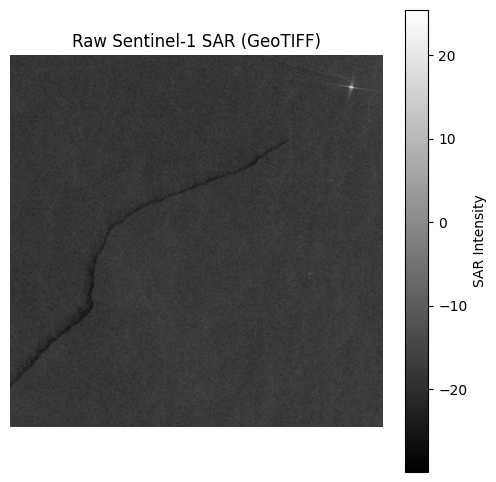

In [12]:
# visualize


TRAIN_IMG = "/content/drive/MyDrive/oilspill/train_img/train_img"

# List first 10 files
files = sorted([f for f in os.listdir(TRAIN_IMG) if f.lower().endswith((".tif", ".tiff"))])
print("Total train tif files:", len(files))
print("First 2 files:", files[:5])

sample_tif = os.path.join(TRAIN_IMG, files[0])
print("Using file:", sample_tif)


import rasterio
import numpy as np

with rasterio.open(sample_tif) as src:
    img = src.read(2)   # first band (SAR intensity)
    profile = src.profile

print("Image shape:", img.shape)
print("Data type  :", img.dtype)
print("Min / Max  :", img.min(), img.max())
print("CRS        :", src.crs)


import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.colorbar(label="SAR Intensity")
plt.title("Raw Sentinel-1 SAR (GeoTIFF)")
plt.axis("off")
plt.show()



In [14]:
!pip install -q rasterio albumentations segmentation-models-pytorch timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:00


In [13]:
import numpy as np
import rasterio
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader

IMG_SIZE = 256

class OilSpillTIFDataset(Dataset):
    def __init__(self, img_dir, mask_dir, augment=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.augment = augment

        self.images = sorted([
            f for f in os.listdir(img_dir)
            if f.lower().endswith((".tif", ".tiff"))
        ])

        self.transform = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p=0.5 if augment else 0),
            A.VerticalFlip(p=0.5 if augment else 0),
            A.RandomRotate90(p=0.5 if augment else 0),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        fname = self.images[idx]

        img_path  = os.path.join(self.img_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname)

        with rasterio.open(img_path) as src:
            b1 = src.read(1).astype(np.float32)
            b2 = src.read(2).astype(np.float32)

        img = np.stack([b1, b2], axis=-1)  # (H, W, 2)

        for c in range(2):
            ch = img[..., c]
            img[..., c] = (ch - ch.min()) / (ch.max() - ch.min() + 1e-6)

        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        mask = (mask > 0).astype(np.float32)

        transformed = self.transform(image=img, mask=mask)

        img  = transformed["image"]              # (2,H,W)
        mask = transformed["mask"].unsqueeze(0)  # (1,H,W)

        return img, mask


In [14]:
batch_size = 16

train_ds = OilSpillTIFDataset(TRAIN_IMG, TRAIN_MASK, augment=True)
val_ds   = OilSpillTIFDataset(VAL_IMG, VAL_MASK, augment=False)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train samples:", len(train_ds))
print("Val samples  :", len(val_ds))


Train samples: 50
Val samples  : 5


In [15]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=2,
    classes=1,
    activation=None
).to(device)



In [16]:
bce_loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def dice_score(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    return ((2 * intersection + eps) / (union + eps)).mean()

def iou_score(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection
    return ((intersection + eps) / (union + eps)).mean()


In [17]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, total_dice, total_iou = 0, 0, 0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)

        loss = bce_loss(logits, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_score(logits, masks).item()
        total_iou  += iou_score(logits, masks).item()

    n = len(loader)
    return total_loss/n, total_dice/n, total_iou/n


def val_one_epoch(model, loader):
    model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = bce_loss(logits, masks)

            total_loss += loss.item()
            total_dice += dice_score(logits, masks).item()
            total_iou  += iou_score(logits, masks).item()

    n = len(loader)
    return total_loss/n, total_dice/n, total_iou/n


In [8]:
# imgs, masks = next(iter(train_loader))

# print("Input shape :", imgs.shape)   # EXPECT: [B, 2, 256, 256]
# print("Mask shape  :", masks.shape)  # EXPECT: [B, 1, 256, 256]

# imgs = imgs.to(device)
# with torch.no_grad():
#     out = model(imgs)

# print("Output shape:", out.shape)    # EXPECT: [B, 1, 256, 256]


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Input shape : torch.Size([16, 2, 256, 256])
Mask shape  : torch.Size([16, 1, 256, 256])
Output shape: torch.Size([16, 1, 256, 256])


In [20]:
SAVE_PATH = "/content/drive/MyDrive/oilspill/unet_tif_best_50.pth"

num_epochs = 50
best_dice = 0

for epoch in range(num_epochs):
    tr_loss, tr_dice, tr_iou = train_one_epoch(model, train_loader)
    val_loss, val_dice, val_iou = val_one_epoch(model, val_loader)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train | Loss: {tr_loss:.4f}  Dice: {tr_dice:.4f}  IoU: {tr_iou:.4f}")
    print(f"Val   | Loss: {val_loss:.4f}  Dice: {val_dice:.4f}  IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), SAVE_PATH)
        print("Best model saved")



Epoch 1/50
Train | Loss: 0.5002  Dice: 0.0563  IoU: 0.0304
Val   | Loss: 0.4958  Dice: 0.0892  IoU: 0.0502
Best model saved



Epoch 2/50
Train | Loss: 0.4927  Dice: 0.0545  IoU: 0.0294
Val   | Loss: 0.4842  Dice: 0.0809  IoU: 0.0449



Epoch 3/50
Train | Loss: 0.4973  Dice: 0.0555  IoU: 0.0305
Val   | Loss: 0.4605  Dice: 0.0826  IoU: 0.0448



Epoch 4/50
Train | Loss: 0.4767  Dice: 0.0710  IoU: 0.0413
Val   | Loss: 0.4394  Dice: 0.0816  IoU: 0.0439



Epoch 5/50
Train | Loss: 0.4611  Dice: 0.0637  IoU: 0.0354
Val   | Loss: 0.4366  Dice: 0.1020  IoU: 0.0562
Best model saved



Epoch 6/50
Train | Loss: 0.4527  Dice: 0.0544  IoU: 0.0311
Val   | Loss: 0.4300  Dice: 0.1121  IoU: 0.0637
Best model saved



Epoch 7/50
Train | Loss: 0.4430  Dice: 0.0958  IoU: 0.0559
Val   | Loss: 0.4239  Dice: 0.1137  IoU: 0.0643
Best model saved



Epoch 8/50
Train | Loss: 0.4337  Dice: 0.0474  IoU: 0.0265
Val   | Loss: 0.4309  Dice: 0.0990  IoU: 0.0541



Epoch 9/50
Train | Loss: 0.4289  Dice: 0.0747  IoU: 0.0440
Val   | Loss: 0.3988  Dice: 0.1228  IoU: 0.0712
Best model saved



Epoch 10/50
Train | Loss: 0.4307  Dice: 0.0699  IoU: 0.0411
Val   | Loss: 0.3933  Dice: 0.1545  IoU: 0.0961
Best model saved



Epoch 11/50
Train | Loss: 0.4155  Dice: 0.1070  IoU: 0.0649
Val   | Loss: 0.3875  Dice: 0.1860  IoU: 0.1152
Best model saved



Epoch 12/50
Train | Loss: 0.4039  Dice: 0.0832  IoU: 0.0490
Val   | Loss: 0.3812  Dice: 0.1508  IoU: 0.0863



Epoch 13/50
Train | Loss: 0.3949  Dice: 0.1016  IoU: 0.0610
Val   | Loss: 0.3682  Dice: 0.1735  IoU: 0.1018



Epoch 14/50
Train | Loss: 0.3820  Dice: 0.0709  IoU: 0.0412
Val   | Loss: 0.3605  Dice: 0.2288  IoU: 0.1415
Best model saved



Epoch 15/50
Train | Loss: 0.3748  Dice: 0.0821  IoU: 0.0491
Val   | Loss: 0.3443  Dice: 0.2732  IoU: 0.1763
Best model saved



Epoch 16/50
Train | Loss: 0.3690  Dice: 0.1908  IoU: 0.1298
Val   | Loss: 0.3416  Dice: 0.2853  IoU: 0.1868
Best model saved



Epoch 17/50
Train | Loss: 0.3544  Dice: 0.2412  IoU: 0.1640
Val   | Loss: 0.3461  Dice: 0.2997  IoU: 0.1997
Best model saved



Epoch 18/50
Train | Loss: 0.3561  Dice: 0.2124  IoU: 0.1473
Val   | Loss: 0.3391  Dice: 0.2984  IoU: 0.1997



Epoch 19/50
Train | Loss: 0.3650  Dice: 0.1995  IoU: 0.1296
Val   | Loss: 0.3308  Dice: 0.3126  IoU: 0.2110
Best model saved



Epoch 20/50
Train | Loss: 0.3498  Dice: 0.2174  IoU: 0.1465
Val   | Loss: 0.3212  Dice: 0.3006  IoU: 0.2040



Epoch 21/50
Train | Loss: 0.3446  Dice: 0.1950  IoU: 0.1351
Val   | Loss: 0.3479  Dice: 0.2685  IoU: 0.1732



Epoch 22/50
Train | Loss: 0.3281  Dice: 0.3393  IoU: 0.2552
Val   | Loss: 0.3535  Dice: 0.2734  IoU: 0.1771



Epoch 23/50
Train | Loss: 0.3147  Dice: 0.1860  IoU: 0.1307
Val   | Loss: 0.3507  Dice: 0.2041  IoU: 0.1293



Epoch 24/50
Train | Loss: 0.3095  Dice: 0.2314  IoU: 0.1569
Val   | Loss: 0.3230  Dice: 0.2067  IoU: 0.1287



Epoch 25/50
Train | Loss: 0.3009  Dice: 0.1821  IoU: 0.1283
Val   | Loss: 0.3051  Dice: 0.2701  IoU: 0.1746



Epoch 26/50
Train | Loss: 0.2979  Dice: 0.2506  IoU: 0.1856
Val   | Loss: 0.2970  Dice: 0.2952  IoU: 0.1951



Epoch 27/50
Train | Loss: 0.3358  Dice: 0.2311  IoU: 0.1633
Val   | Loss: 0.2746  Dice: 0.3160  IoU: 0.2166
Best model saved



Epoch 28/50
Train | Loss: 0.2862  Dice: 0.2968  IoU: 0.2064
Val   | Loss: 0.2834  Dice: 0.3038  IoU: 0.2031



Epoch 29/50
Train | Loss: 0.2864  Dice: 0.2173  IoU: 0.1585
Val   | Loss: 0.2932  Dice: 0.3018  IoU: 0.2026



Epoch 30/50
Train | Loss: 0.2847  Dice: 0.2810  IoU: 0.2090
Val   | Loss: 0.2936  Dice: 0.2970  IoU: 0.1963



Epoch 31/50
Train | Loss: 0.2781  Dice: 0.2461  IoU: 0.1775
Val   | Loss: 0.2938  Dice: 0.3107  IoU: 0.2089



Epoch 32/50
Train | Loss: 0.3311  Dice: 0.2537  IoU: 0.1730
Val   | Loss: 0.2692  Dice: 0.3581  IoU: 0.2548
Best model saved



Epoch 33/50
Train | Loss: 0.2666  Dice: 0.3493  IoU: 0.2511
Val   | Loss: 0.2714  Dice: 0.3998  IoU: 0.2861
Best model saved



Epoch 34/50
Train | Loss: 0.2635  Dice: 0.3694  IoU: 0.2685
Val   | Loss: 0.2625  Dice: 0.4204  IoU: 0.2998
Best model saved



Epoch 35/50
Train | Loss: 0.2537  Dice: 0.2976  IoU: 0.2183
Val   | Loss: 0.2459  Dice: 0.4157  IoU: 0.2948



Epoch 36/50
Train | Loss: 0.2621  Dice: 0.3415  IoU: 0.2478
Val   | Loss: 0.2309  Dice: 0.3702  IoU: 0.2675



Epoch 37/50
Train | Loss: 0.2435  Dice: 0.3885  IoU: 0.2790
Val   | Loss: 0.2268  Dice: 0.3701  IoU: 0.2694



Epoch 38/50
Train | Loss: 0.2424  Dice: 0.2808  IoU: 0.2041
Val   | Loss: 0.2308  Dice: 0.3822  IoU: 0.2804



Epoch 39/50
Train | Loss: 0.2380  Dice: 0.3571  IoU: 0.2634
Val   | Loss: 0.2255  Dice: 0.3818  IoU: 0.2791



Epoch 40/50
Train | Loss: 0.2385  Dice: 0.3398  IoU: 0.2491
Val   | Loss: 0.2194  Dice: 0.3706  IoU: 0.2724



Epoch 41/50
Train | Loss: 0.2283  Dice: 0.3194  IoU: 0.2369
Val   | Loss: 0.2159  Dice: 0.3728  IoU: 0.2735



Epoch 42/50
Train | Loss: 0.2258  Dice: 0.3674  IoU: 0.2770
Val   | Loss: 0.2105  Dice: 0.3688  IoU: 0.2738



Epoch 43/50
Train | Loss: 0.2290  Dice: 0.3676  IoU: 0.2758
Val   | Loss: 0.2060  Dice: 0.3915  IoU: 0.2900



Epoch 44/50
Train | Loss: 0.2212  Dice: 0.3204  IoU: 0.2476
Val   | Loss: 0.2085  Dice: 0.4654  IoU: 0.3438
Best model saved



Epoch 45/50
Train | Loss: 0.2173  Dice: 0.3981  IoU: 0.2915
Val   | Loss: 0.2091  Dice: 0.4614  IoU: 0.3334



Epoch 46/50
Train | Loss: 0.2218  Dice: 0.4320  IoU: 0.3284
Val   | Loss: 0.2095  Dice: 0.5306  IoU: 0.3772
Best model saved



Epoch 47/50
Train | Loss: 0.2157  Dice: 0.3814  IoU: 0.2838
Val   | Loss: 0.2442  Dice: 0.4910  IoU: 0.3506



Epoch 48/50
Train | Loss: 0.2125  Dice: 0.3807  IoU: 0.2801
Val   | Loss: 0.2432  Dice: 0.4961  IoU: 0.3508



Epoch 49/50
Train | Loss: 0.2126  Dice: 0.3271  IoU: 0.2426
Val   | Loss: 0.2434  Dice: 0.4377  IoU: 0.3123



Epoch 50/50
Train | Loss: 0.2077  Dice: 0.4676  IoU: 0.3694
Val   | Loss: 0.2444  Dice: 0.4859  IoU: 0.3562


In [21]:
import torch
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_PATH = "/content/drive/MyDrive/oilspill/unet_tif_best_50.pth"

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=2,
    classes=1,
    activation=None
).to(device)

model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.eval()

print("Model loaded")


Model loaded


In [22]:
import rasterio
import numpy as np
from albumentations import Resize
from albumentations.pytorch import ToTensorV2

TEST_TIF = "/content/drive/MyDrive/oilspill/test/test_1.tiff"

with rasterio.open(TEST_TIF) as src:
    b1 = src.read(1).astype(np.float32)
    b2 = src.read(2).astype(np.float32)
    profile = src.profile

img = np.stack([b1, b2], axis=-1)  # (H,W,2)

for c in range(2):
    ch = img[..., c]
    img[..., c] = (ch - ch.min()) / (ch.max() - ch.min() + 1e-6)

H, W, _ = img.shape
print("Original size:", img.shape)

transform = Resize(256, 256)
img_resized = transform(image=img)["image"]

img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).to(device)


Original size: (683, 946, 2)


In [23]:
with torch.no_grad():
    logits = model(img_tensor)
    prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

prob_full = np.array(
    Resize(H, W)(image=prob)["image"]
)

binary_mask = (prob_full > 0.5).astype(np.uint8)


In [24]:
OUT_MASK = "/content/drive/MyDrive/oilspill/test/test_1_pred.tif"

profile.update({
    "count": 1,
    "dtype": "uint8"
})

with rasterio.open(OUT_MASK, "w", **profile) as dst:
    dst.write(binary_mask, 1)

print("Prediction saved to:", OUT_MASK)


Prediction saved to: /content/drive/MyDrive/oilspill/test/test_1_pred.tif


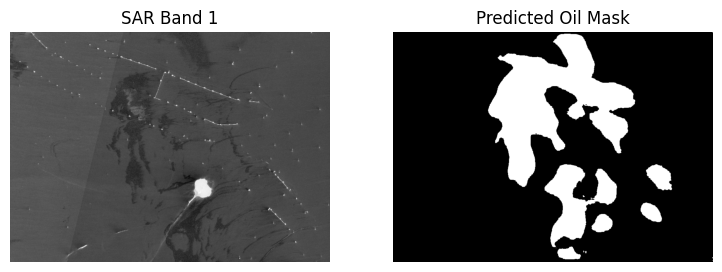

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.title("SAR Band 1")
plt.imshow(b1, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted Oil Mask")
plt.imshow(binary_mask, cmap="gray")
plt.axis("off")


plt.show()


Original size: (902, 1250, 2)


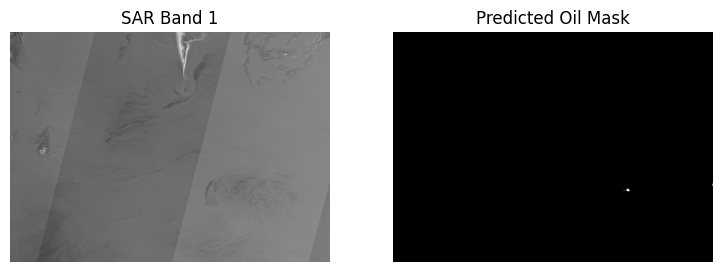

In [27]:
import rasterio
import numpy as np
from albumentations import Resize
from albumentations.pytorch import ToTensorV2

TEST_TIF = "/content/drive/MyDrive/oilspill/test/test_2.tiff"

with rasterio.open(TEST_TIF) as src:
    b1 = src.read(1).astype(np.float32)
    b2 = src.read(2).astype(np.float32)
    profile = src.profile

img = np.stack([b1, b2], axis=-1)  # (H,W,2)

for c in range(2):
    ch = img[..., c]
    img[..., c] = (ch - ch.min()) / (ch.max() - ch.min() + 1e-6)

H, W, _ = img.shape
print("Original size:", img.shape)

transform = Resize(256, 256)
img_resized = transform(image=img)["image"]

img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(img_tensor)
    prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

prob_full = np.array(
    Resize(H, W)(image=prob)["image"]
)

binary_mask = (prob_full > 0.5).astype(np.uint8)

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.title("SAR Band 1")
plt.imshow(b1, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted Oil Mask")
plt.imshow(binary_mask, cmap="gray")
plt.axis("off")


plt.show()

